In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
%matplotlib inline

# Topic Modelling
Now with the dataset prepared, on to topic modelling. 

<br><br>
The handler below helps me capture some metrics that gensim calculates during training runs but does not output or save in any way. In particular, I need to capture:
* Perplexity - this is a measure of how likely it is that the topic model (as it currently stands) generated a given text sample. So, we expect to see perplexity decreasing over training runs; otherwise the model is not fitting the documents well. However, perplexity is meaningful only for in-model tuning and comparisons. 
* Topic difference - this is a measure of how much the topics changed over the last training iteration. As topic difference approaches zero, it indicates that the model is converging. 
* Per-word bound - 

In [2]:
from gensim import corpora
import gensim, logging, io, os
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
handler = logging.FileHandler('training_output.log')


# The handler above is somthing I needed with respect to logging.
# Gensim performs various calculations while training the LDA model that I am using, but the only way to see them
# is in the logging outputs.
# Specifically, I need to capture the perplexity values during training to verify that perplexity is decreasing.
# This metric is needed to compare models and to do hyperparameter tuning. 


# The following blog post was helpful to me in figure out how to make the log handler I needed.
# https://fangpenlin.com/posts/2012/08/26/good-logging-practice-in-python/



In [3]:
df = pd.read_csv('amazon_reviews_clean.csv')
df.set_index('Id', inplace=True, verify_integrity=True)
df.head()

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  Unnamed: 0.1.1.1  \
Id                                                               
14           0             0               0                 0   
15           1             1               1                 1   
16           2             2               2                 2   
17           3             3               3                 3   
18           4             4               4                 4   

    Unnamed: 0.1.1.1.1   ProductId          UserId          ProfileName  \
Id                                                                        
14                  13  B001GVISJM  A18ECVX2RJ7HUE      willie "roadie"   
15                  14  B001GVISJM  A2MUGFV2TDQ47K  Lynrie "Oh HELL no"   
16                  15  B001GVISJM  A1CZX3CP8IKQIJ         Brian A. Lee   
17                  16  B001GVISJM  A3KLWF6WQ5BNYO       Erica Neathery   
18                  17  B001GVISJM   AFKW14U97Z6QO                Becca   

    HelpfulnessNumerator  HelpfulnessDenominator    ...     \
Id                                                  ...      
14                     2                       2    ...      
15                     4                       5    ...      
16                     4                       5    ...      
17                     0                       0    ...      
18                     0                       0    ...      

                                          clean_coded  \
Id                                                      
14  good GOODREVIEW flavor come securely GOODREVIE...   
15  strawberry twizzlers be guilty BADREVIEW pleas...   
16  daughter love GOODREVIEW twizzlers shipment si...   
17  love GOODREVIEW eat be good GOODREVIEW watch t...   
18  be very satisfied GOODREVIEW twizzler purchase...   

                                         clean_valenc  \
Id                                                      
14  ['good', 'GOODREVIEW', 'flavor', '!', 'come', ...   
15  ['strawberry', 'twizzlers', 'be', 'guilty', 'B...   
16  ['daughter', 'love', 'VGOODREVIEW', 'twizzlers...   
17  ['love', 'VGOODREVIEW', 'eat', 'be', 'good', '...   
18  ['be', 'very', 'satisfied', 'GOODREVIEW', 'twi...   

                                        clean_valence codecount_GOOD  \
Id                                                                     
14  good GOODREVIEW flavor come securely GOODREVIE...              5   
15  strawberry twizzlers be guilty BADREVIEW pleas...              1   
16  daughter love VGOODREVIEW twizzlers shipment s...              1   
17  love VGOODREVIEW eat be good GOODREVIEW watch ...              4   
18  be very satisfied GOODREVIEW twizzler purchase...              2   

    codecount_BAD valencecount_GOOD valencecount_VGOOD valencecount_BAD  \
Id                                                                        
14              0                 5                  2                0   
15              1                 1                  1                1   
16              0                 1                  1                0   
17              1                 4                  1                1   
18              0                 2                  1                0   

   valencecount_VBAD Sentiment  
Id                              
14                 0         1  
15                 0         1  
16                 0         1  
17                 0         0  
18                 0         1  

[5 rows x 32 columns]

In [3]:
# get the count of reviews present for each product
review_counts = df['ProductId'].value_counts().sort_values()
review_counts.tail(12)

B001VJ0B0I    479
B000PDY3HI    486
B002IEZJMA    487
B006MONQMC    491
B005ZBZLT4    506
B003GTR8IO    530
B005K4Q34S    541
B0013A0QXC    542
B000NMJWZO    542
B000KV61FC    556
B001EO5Q64    567
B0026RQTGE    630
Name: ProductId, dtype: int64

In [5]:
# For the LDA model, I'd like to filter out the top 3 most frequently used tokens in the corpus
# For most products, the most frequent tokens  refer to the product itself in a generic way and also contain what we might consider stop words
# but didn't want to remove earlier because they are needed for part-of-speech tagging
# (e.g., "product," "coconut," "oil" as well as "have," "be," etc.)
# this helper function is a slight modification of one of gensim's built-in methods -
# I don't want to remove the codewords I've inserted, and those also end up in the top 3 quite often, 
# particularly after 

def remove_freq(dictionary, n):
    logger = logging.getLogger('gensim.corpora.dictionary')
    save = set(['GOODREVIEW', 'BADREVIEW', 'VGOODREVIEW', 'VBADREVIEW'])
    most_frequent_ids = (v for v in (dictionary.token2id).values() if dictionary[v] not in save)
    most_frequent_ids = sorted(most_frequent_ids, key=dictionary.dfs.get, reverse=True)
    most_frequent_ids = most_frequent_ids[:n]
    # do the actual filtering, then rebuild dictionary to remove gaps in ids
    most_frequent_words = [(dictionary[idx], dictionary.dfs.get(idx, 0)) for idx in most_frequent_ids]
    logger.info("discarding %i tokens: %s...", len(most_frequent_ids), most_frequent_words[:10])

    dictionary.filter_tokens(bad_ids=most_frequent_ids)
    logger.info("resulting dictionary: %s", dictionary)

# the next few helper functions deal with extracting metrics of interest from gensim's logger, 
# which are being dumped into a log file as training runs
# I am capturing bounds, perplexity, and per-word topic differences
    
    
import itertools
# thanks to these SO answers https://stackoverflow.com/questions/6213063/python-read-next
# and https://stackoverflow.com/questions/5434891/iterate-a-list-as-pair-current-next-in-python
# for showing a way to deal with lines of a file in groups of three
def threes(iterator):
    "s -> (s0,s1,s2), (s1,s2,s3), (s2, s3, s4), ..."
    a, b, c = itertools.tee(iterator, 3)
    next(b, None)
    next(c, None)
    next(c, None)
    return zip(a, b, c)

def capture_logs(): # capture the perplexity, per-word bound, and topic difference values from the logger and save
    perplexity_log = []
    perplex = {}
    bounds = {}
    diff = {}
    with open("training_output.log", 'r') as f:
        for line in f:
            if re.match("|".join([r'.*topic diff.*', r'.*per-word.*', r'.*PROGRESS.*']), line):
                perplexity_log.append(line)
    for a, b, c in threes(perplexity_log): 
        if re.match(r'.*PROGRESS.*', a):
            pass_val = int(re.search(r'\d*, at', a).group(0).split(',')[0])
            if re.match(r'.*topic diff.*', b):
                d = float(re.search(r'\d*\.\d*', b).group(0).split()[0])
                diff[pass_val] = d
            if re.match(r'.*per-word.*', b): # these may show up in the second line of the group as well
                b = float(re.search(r'.\d*\.\d* per', b).group(0).split()[0])
                p = float(re.search(r'\d*\.\d perplexity', b).group(0).split()[0])
                perplex[pass_val] = p
                bounds[pass_val] = b
            if re.match(r'.*per-word.*', c):
                b = float(re.search(r'.\d*\.\d* per', c).group(0).split()[0])
                p = float(re.search(r'\d*\.\d perplexity', c).group(0).split()[0])
                perplex[pass_val] = p
                bounds[pass_val] = b
    return bounds, perplex, diff

def perplexity_decreasing(perplex): #checks if the perplexity decreased during the last two training passes
    passes = sorted(perplex.keys())
    start = passes[-2]
    end = passes[-1]
    if perplex[start] > perplex[end]:
        return True
    else:
        return False

In [6]:
# this function runs trains an LDA model for a single product, 
# constructing any number of topics over any number of passes
def run_lda(product, n_topics, n_passes, texts, save_path):
    """
    This function trains an LDA model fo a single product, 
    constructing any number of topics over any number of training passes.
    product: the string product ID
    n_topics: number of topics desired
    n_passes: number of training passes to make
    texts: the corpus to use (column name from the main dataframe)
    save_path: where to save the model outputs
    returns a dataframe with the results of the training 
    """
    os.remove('training_output.log')
    logger = logging.getLogger('gensim.models.ldamodel')
    handler = logging.FileHandler('training_output.log')
    handler.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s : %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    data = df[df['ProductId']==product]
    texts = data[texts].str.split()
    dictionary = corpora.Dictionary(texts)
    remove_freq(dictionary, 3)
    corpus = [dictionary.doc2bow(text) for text in texts]
    corpora.MmCorpus.serialize('/tmp/corpus.mm', corpus)
    mm = corpora.MmCorpus('/tmp/corpus.mm')
    chunk_size = review_counts[product]/3
    lda = gensim.models.ldamodel.LdaModel(corpus=mm, id2word=dictionary, num_topics=n_topics, update_every=1, chunksize=chunk_size, passes=n_passes)
    bounds, perplex, diff = capture_logs()
    results = pd.DataFrame(index=[product], data={'num_topics': n_topics, 'chunk': chunk_size, 'passes': n_passes})
    results['per-word bounds'] = [bounds]
    results['perplexity'] = [perplex]
    results['topic diff'] = [diff]
    p = sorted(perplex.keys())
    end = p[-1]
    results['final perplexity'] = perplex[end]
    d = sorted(diff.keys())
    end = p[-1]
    results['final topic diff'] = diff[end]
    if perplexity_decreasing:
        results['perplexity decreasing'] = True
    else: 
        results['perplexity_decreasing'] = False
    for n in range(0,n_topics):
        topic = lda.show_topic(n, 20)
        results['topic {}'.format(n)] = [topic]
    lda.save('./{}/{}'.format(save_path, product))
    lda.clear()
    return results


In [4]:
# get a couple product groups to work with - the 10 and 20 products with the largest number of reviews
top_ten = review_counts.tail(10).index.values
top_twenty = review_counts.tail(20).index.values

In [ ]:
# run LDA for the top ten or top twenty products (by # of reviews), capture key outputs to a dataframe,
# and save the model for each product off as we go so it can be used for predictions later

# create a dataframe to save the training results for the top 10 products (by # of reviews)
top_ten_results_50 = pd.DataFrame(columns = ['num_topics', 'chunk', 'passes', 'per-word bounds', 'perplexity', 
                                          'final perplexity', 'perplexity decreasing', 
                                          'topic diff', 'final topic diff'])

#top_twenty_results = pd.DataFrame(columns = ['num_topics', 'chunk', 'passes', 'per-word bounds', 'perplexity', 
#                                          'final perplexity', 'perplexity decreasing', 
#                                          'topic diff', 'final topic diff'])

# run LDA training to construct 10 topics over 50 training passes for the top ten products
for product in top_ten:
    results = run_lda(product, 10, 50, 'clean_coded', 'outputs')
    top_ten_results_50 = pd.concat([top_ten_results_50, results], axis=0)


2018-03-28 12:16:39,353 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-03-28 12:16:39,452 : INFO : built Dictionary(2970 unique tokens: ['begs', 'diabetic', 'oversight', 'chef', 'dairy']...) from 487 documents (total 41120 corpus positions)
2018-03-28 12:16:39,463 : INFO : discarding 3 tokens: [('be', 478), ('coffee', 444), ('not', 397)]...
2018-03-28 12:16:39,470 : INFO : resulting dictionary: Dictionary(2967 unique tokens: ['begs', 'diabetic', 'oversight', 'chef', 'dairy']...)
2018-03-28 12:16:39,545 : INFO : storing corpus in Matrix Market format to /tmp/corpus.mm
2018-03-28 12:16:39,570 : INFO : saving sparse matrix to /tmp/corpus.mm
2018-03-28 12:16:39,573 : INFO : PROGRESS: saving document #0
2018-03-28 12:16:39,676 : INFO : saved 487x2967 matrix, density=1.715% (24783/1444929)
2018-03-28 12:16:39,679 : INFO : saving MmCorpus index to /tmp/corpus.mm.index
2018-03-28 12:16:39,687 : INFO : loaded corpus index from /tmp/corpus.mm.index
2018-03-28 12:16:39,690 : 

In [10]:
# examine the outputs for each product
top_ten_results_50.head(2)

chunk  final perplexity  final topic diff num_topics passes  \
B002IEZJMA  162.333333              21.0          0.059757         10     50   
B006MONQMC  163.666667              29.2          0.067150         10     50   

                                              per-word bounds  \
B002IEZJMA  {0: -7.034, 1: -5.711, 2: -5.462, 3: -5.247, 4...   
B006MONQMC  {0: -7.033, 1: -5.798, 2: -5.416, 3: -5.195, 4...   

                                                   perplexity  \
B002IEZJMA  {0: 131.1, 1: 52.4, 2: 44.1, 3: 38.0, 4: 33.0,...   
B006MONQMC  {0: 131.0, 1: 55.6, 2: 42.7, 3: 36.6, 4: 33.9,...   

           perplexity decreasing  \
B002IEZJMA                  True   
B006MONQMC                  True   

                                                      topic 0  \
B002IEZJMA  [(nutritional, 0.00702988), (corn, 0.00608229)...   
B006MONQMC  [(GOODREVIEW, 0.0982515), (more, 0.0359792), (...   

                                                      topic 1  \
B002IEZJMA  [(GOODREVIEW, 0.112632), (drink, 0.0545757), (...   
B006MONQMC  [(GOODREVIEW, 0.084481), (BADREVIEW, 0.0515607...   

                                                      topic 2  \
B002IEZJMA  [(GOODREVIEW, 0.103715), (BADREVIEW, 0.0507678...   
B006MONQMC  [(GOODREVIEW, 0.0255223), (bottle, 0.0105667),...   

                                                      topic 3  \
B002IEZJMA  [(nasty, 0.0134149), (hop, 0.00928955), (tinny...   
B006MONQMC  [(admit, 0.0509879), (cap, 0.0121954), (exactl...   

                                                      topic 4  \
B002IEZJMA  [(heavily, 0.00634428), (nonfat, 0.00634406), ...   
B006MONQMC  [(wrap, 0.116537), (iced, 0.00748606), (doctor...   

                                                      topic 5  \
B002IEZJMA  [(accord, 0.0106684), (benefit, 0.00839055), (...   
B006MONQMC  [(concentrate, 0.0449986), (must, 0.0429378), ...   

                                                      topic 6  \
B002IEZJMA  [(blend, 0.00984976), (several, 0.00731391), (...   
B006MONQMC  [(nobody, 0.00525027), (purple, 0.00412003), (...   

                                                      topic 7  \
B002IEZJMA  [(hint, 0.017784), (normal, 0.0111591), (ton, ...   
B006MONQMC  [(vs, 0.00800982), (yada, 0.00606799), (ignore...   

                                                      topic 8  \
B002IEZJMA  [(awake, 0.0124883), (stay, 0.0105523), (wake,...   
B006MONQMC  [(potassium, 0.0284551), (acid, 0.0225651), (l...   

                                                      topic 9  \
B002IEZJMA  [(first, 0.0195447), (cent, 0.0180246), (milli...   
B006MONQMC  [(b, 0.0480608), (taurine, 0.0392164), (vitami...   

                                                   topic diff  
B002IEZJMA  {0: 0.588477, 1: 0.354502, 2: 0.275668, 3: 0.2...  
B006MONQMC  {0: 0.789149, 1: 0.55948, 2: 0.480907, 3: 0.43...

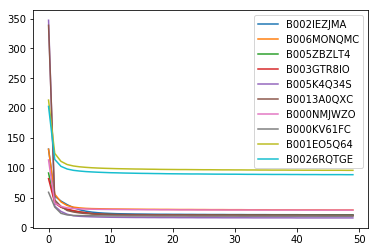

In [11]:
# examine the perplexity scores over the course of the runs
fig, ax = plt.subplots()
labels=[]
for product in top_ten:
    labels.append(product)
    p = sorted(top_ten_results_50.loc[product].perplexity.items())
    x,y = zip(*p)
    plt.plot(x,y, label=product)
plt.legend()

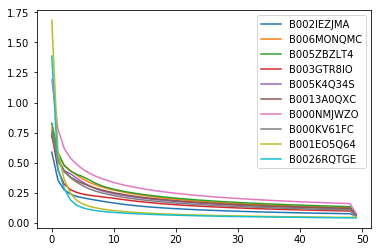

In [12]:
# examine the topic difference values over the course of the runs
# when topic diff stops decreasing, the model has converged
fig, ax = plt.subplots()
labels=[]
for product in top_ten:
    labels.append(product)
    p = sorted(top_ten_results_50.loc[product]['topic diff'].items())
    x,y = zip(*p)
    plt.plot(x,y, label=product)
plt.legend()

Although perplexity and topic difference both decline over the course of the runs which is a good sign. 

Once having completed training to produce a baseline model for the subset of products, it's time to tune them and see if the results can be improved with different parameter combinations. There are a variety of metrics and methods for tuning a topic model - the one I have chosen to use here is a coherence pipeline. 

I like this method and the implementation in gensim because it is relatively straightforward to interpret and can also be compared across models (unlike some of the other metrics). Using the cosine similarity function means that the outputs will be between 0 and 1, with values closer to 1 indicating greater similarity between two vectors (and therefore greater coherence within the topic in the aggregate). 

In addition, tuning based on coherence seems to produce better results in that the topics are more human-interpretable. [paper] provides a good discussion of the superiority of coherence vs. other metrics like perplexity, where a topic may have a better "score" in the mathematical sense, but at times the higher-scoring topic models make less sense when evaluated by humans. 

In [7]:
from gensim.models.coherencemodel import CoherenceModel

In [108]:
coherence_top_ten = {}

# for each of my ten products, I will use gensim's implementation of the coherence pipeline 
# to score the initial LDA model and determine if additional tuning is needed
for product in top_ten:
    data = df[df['ProductId']==product]
    # prepare the corpus
    texts = data['clean_coded'].str.split()
    dictionary = corpora.Dictionary(texts)
    remove_freq(dictionary, 10)
    corpus = [dictionary.doc2bow(text) for text in texts]
    # load in the trained LDA model for the product
    lda = gensim.models.ldamodel.LdaModel.load("./outputs/{}".format(product))
    # build the coherence model
    cm = CoherenceModel(model=lda, corpus=corpus, texts = texts, coherence='c_v')  # model is the trained topic model
    coherence_top_ten[product] = cm.get_coherence()

2018-04-04 16:09:30,460 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-04-04 16:09:30,561 : INFO : built Dictionary(2970 unique tokens: ['trieste', 'robusta', 'cool', 'fool', 'coco']...) from 487 documents (total 41120 corpus positions)
2018-04-04 16:09:30,569 : INFO : discarding 10 tokens: [('be', 478), ('coffee', 444), ('not', 397), ('drink', 372), ('have', 329), ('like', 325), ('taste', 316), ('do', 278), ('flavor', 232), ('good', 211)]...
2018-04-04 16:09:30,577 : INFO : resulting dictionary: Dictionary(2960 unique tokens: ['trieste', 'robusta', 'cool', 'fool', 'coco']...)
2018-04-04 16:09:30,653 : INFO : loading LdaModel object from ./outputs/B002IEZJMA


FileNotFoundError: [Errno 2] No such file or directory: './outputs/B002IEZJMA'

In [14]:
# examine the coherences for the initial LDA model for each of the top ten products
# values closer to 1 are better and I am setting an initial threshold of 0.5
coherence_top_ten

{'B000KV61FC': 0.50095254672240019,
 'B000NMJWZO': 0.43518244279565355,
 'B0013A0QXC': 0.42148795691398322,
 'B001EO5Q64': 0.46335840977804743,
 'B0026RQTGE': 0.43150198944962248,
 'B002IEZJMA': 0.48855877203085862,
 'B003GTR8IO': 0.44639241362479093,
 'B005K4Q34S': 0.41719904290870452,
 'B005ZBZLT4': 0.41515729796048007,
 'B006MONQMC': 0.40485796471755142}

In [8]:
# this function tunes an LDA model for a single product, by grid searching over various numbers of topics,
# over different numbers of passes, using a specified text set (cleaned, coded, valence coded, etc.)
from shutil import copyfile
from sys import exit
from gensim.models.coherencemodel import CoherenceModel


def tune_lda(product, n_topics, n_passes, input_text, save_path):
    os.remove('training_output.log')
    logger = logging.getLogger('gensim.models.ldamodel')
    handler = logging.FileHandler('training_output.log')
    handler.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s : %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    data = df[df['ProductId']==product]
    texts = data[input_text].str.split()
    dictionary = corpora.Dictionary(texts)
    remove_freq(dictionary, 10)
    corpus = [dictionary.doc2bow(text) for text in texts]
    corpora.MmCorpus.serialize('/tmp/corpus.mm', corpus)
    mm = corpora.MmCorpus('/tmp/corpus.mm')
    chunk_size = review_counts[product]/3
    output = pd.DataFrame(columns=['product', 'num_topics', 'chunk', 'passes', 'per-word bounds', 'perplexity', 'topic diff',
                                  'final perplexity', 'final topic diff', 'perplexity decreasing', 'coherence'])
    for t in n_topics:
        for p in n_passes:
            print('training LDA with {} topics over {} passes'.format(t, p))
            lda = gensim.models.ldamodel.LdaModel(corpus=mm, id2word=dictionary, \
                                                  num_topics=t, update_every=1, \
                                                  chunksize=chunk_size, passes=p, random_state=42)
            bounds, perplex, diff = capture_logs()
            results = {'product': product, 'num_topics': t, 'chunk': chunk_size, 'passes': p}
            results['per-word bounds'] = [bounds]
            results['perplexity'] = [perplex]
            results['topic diff'] = [diff]
            per = sorted(perplex.keys())
            end = per[-1]
            results['final perplexity'] = perplex[end]
            d = sorted(diff.keys())
            end = d[-1]
            results['final topic diff'] = diff[end]
            if perplexity_decreasing:
                results['perplexity decreasing'] = True
            else: 
                results['perplexity_decreasing'] = False
            for n in range(0,t):
                topic = lda.show_topic(n, 20)
                results['topic {}'.format(n)] = [topic]
            lda.save('./outputs/{}_{}_{}'.format(product, t, p))
            cm = CoherenceModel(model=lda, corpus=corpus, texts = texts, coherence='c_v')
            results['coherence'] = cm.get_coherence()
            output = pd.concat([output, pd.DataFrame(data=results)], axis=0)
            lda.clear()
    return output

# this function finds the best result (maximizing coherence) from the grid search run
# the results are saved to final output dataframe and the LDA model is also saved off

def save_best(output, final_results):
    output.reset_index(inplace=True)
    best_idx = output['coherence'].idxmax()
    product = output.loc[best_idx, 'product']
    print('best results for product {}:'.format(product))
    print(output.loc[best_idx])
    final_results = final_results.append(output.loc[best_idx], ignore_index=True)
    t = output.loc[best_idx, 'num_topics']
    p = output.loc[best_idx, 'passes']
    lda = gensim.models.ldamodel.LdaModel.load("./outputs/{}_{}_{}".format(product, t, p))
    lda.save('./outputs/final_models/{}_{}_{}'.format(product, t, p))
    lda.clear()
    del output
    print("Final model saved for product {} with {} topics over {} passes.".format(product, t, p))
    return final_results

In [ ]:
# create a dataframe to house the results of the model tuning from an initial grid search
gs_results = pd.DataFrame(columns=['product', 'num_topics', 'chunk', 'passes', 'per-word bounds', 'perplexity', 'topic diff',
                                  'final perplexity', 'final topic diff', 'perplexity decreasing', 'coherence'])

# for each of the top ten products, grid search over a combination of n_passes and n_topics 
# save the parameter combinations (and saved model) of the model with the highest coherence score
for product in top_ten:
    output = tune_lda(product=product, n_passes=[50, 100], n_topics=[6, 10, 12], save_path='outputs',\
                      input_text='clean_coded')
    gs_results = save_best(output, gs_results)

2018-04-05 12:25:55,336 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-04-05 12:25:55,419 : INFO : built Dictionary(2970 unique tokens: ['moment', 'brownie', 'only', 'seving', 'screw']...) from 487 documents (total 41120 corpus positions)
2018-04-05 12:25:55,426 : INFO : discarding 10 tokens: [('be', 478), ('coffee', 444), ('not', 397), ('drink', 372), ('have', 329), ('like', 325), ('taste', 316), ('do', 278), ('flavor', 232), ('good', 211)]...
2018-04-05 12:25:55,433 : INFO : resulting dictionary: Dictionary(2960 unique tokens: ['moment', 'brownie', 'only', 'seving', 'screw']...)
2018-04-05 12:25:55,515 : INFO : storing corpus in Matrix Market format to /tmp/corpus.mm
2018-04-05 12:25:55,518 : INFO : saving sparse matrix to /tmp/corpus.mm
2018-04-05 12:25:55,519 : INFO : PROGRESS: saving document #0
2018-04-05 12:25:55,659 : INFO : saved 487x2960 matrix, density=1.576% (22720/1441520)
2018-04-05 12:25:55,661 : INFO : saving MmCorpus index to /tmp/corpus.mm.index
2

training LDA with 6 topics over 50 passes


2018-04-05 12:25:55,954 : INFO : running online (multi-pass) LDA training, 6 topics, 50 passes over the supplied corpus of 487 documents, updating model once every 162 documents, evaluating perplexity every 487 documents, iterating 50x with a convergence threshold of 0.001000
2018-04-05 12:25:56,013 : INFO : PROGRESS: pass 0, at document #162/487
2018-04-05 12:25:57,092 : INFO : merging changes from 162 documents into a model of 487 documents
2018-04-05 12:25:57,167 : INFO : topic #4 (0.167): 0.077*"GOODREVIEW" + 0.027*"BADREVIEW" + 0.016*"sweet" + 0.013*"so" + 0.013*"espresso" + 0.010*"sugar" + 0.007*"illy" + 0.006*"calorie" + 0.006*"high" + 0.006*"no"
2018-04-05 12:25:57,168 : INFO : topic #1 (0.167): 0.085*"GOODREVIEW" + 0.058*"BADREVIEW" + 0.015*"espresso" + 0.012*"sugar" + 0.012*"illy" + 0.011*"would" + 0.010*"than" + 0.008*"much" + 0.007*"sweet" + 0.007*"so"
2018-04-05 12:25:57,170 : INFO : topic #5 (0.167): 0.081*"GOODREVIEW" + 0.034*"BADREVIEW" + 0.018*"sugar" + 0.017*"espresso

training LDA with 6 topics over 100 passes


2018-04-05 12:26:57,920 : INFO : running online (multi-pass) LDA training, 6 topics, 100 passes over the supplied corpus of 487 documents, updating model once every 162 documents, evaluating perplexity every 487 documents, iterating 50x with a convergence threshold of 0.001000
2018-04-05 12:26:57,966 : INFO : PROGRESS: pass 0, at document #162/487
2018-04-05 12:26:59,027 : INFO : merging changes from 162 documents into a model of 487 documents
2018-04-05 12:26:59,104 : INFO : topic #4 (0.167): 0.077*"GOODREVIEW" + 0.027*"BADREVIEW" + 0.016*"sweet" + 0.013*"so" + 0.013*"espresso" + 0.010*"sugar" + 0.007*"illy" + 0.006*"calorie" + 0.006*"high" + 0.006*"no"
2018-04-05 12:26:59,106 : INFO : topic #1 (0.167): 0.085*"GOODREVIEW" + 0.058*"BADREVIEW" + 0.015*"espresso" + 0.012*"sugar" + 0.012*"illy" + 0.011*"would" + 0.010*"than" + 0.008*"much" + 0.007*"sweet" + 0.007*"so"
2018-04-05 12:26:59,107 : INFO : topic #5 (0.167): 0.081*"GOODREVIEW" + 0.034*"BADREVIEW" + 0.018*"sugar" + 0.017*"espress

training LDA with 12 topics over 100 passes


2018-04-05 20:47:23,531 : INFO : running online (multi-pass) LDA training, 12 topics, 100 passes over the supplied corpus of 506 documents, updating model once every 168 documents, evaluating perplexity every 506 documents, iterating 50x with a convergence threshold of 0.001000
2018-04-05 20:47:23,565 : INFO : PROGRESS: pass 0, at document #168/506
2018-04-05 20:47:24,493 : INFO : merging changes from 168 documents into a model of 506 documents
2018-04-05 20:47:24,544 : INFO : topic #1 (0.083): 0.119*"GOODREVIEW" + 0.036*"BADREVIEW" + 0.016*"strong" + 0.013*"bag" + 0.013*"fog" + 0.011*"chaser" + 0.011*"use" + 0.011*"one" + 0.010*"flavor" + 0.010*"very"
2018-04-05 20:47:24,545 : INFO : topic #8 (0.083): 0.048*"GOODREVIEW" + 0.013*"try" + 0.012*"great" + 0.011*"than" + 0.011*"ve" + 0.011*"more" + 0.011*"favorite" + 0.010*"new" + 0.010*"chaser" + 0.010*"plastic"
2018-04-05 20:47:24,547 : INFO : topic #10 (0.083): 0.043*"GOODREVIEW" + 0.027*"very" + 0.023*"BADREVIEW" + 0.020*"try" + 0.014*

training LDA with 12 topics over 100 passes


2018-04-05 21:23:15,998 : INFO : running online (multi-pass) LDA training, 12 topics, 100 passes over the supplied corpus of 541 documents, updating model once every 180 documents, evaluating perplexity every 541 documents, iterating 50x with a convergence threshold of 0.001000
2018-04-05 21:23:16,025 : INFO : PROGRESS: pass 0, at document #180/541
2018-04-05 21:23:17,119 : INFO : merging changes from 180 documents into a model of 541 documents
2018-04-05 21:23:17,157 : INFO : topic #0 (0.083): 0.087*"GOODREVIEW" + 0.045*"BADREVIEW" + 0.020*"so" + 0.018*"buy" + 0.016*"try" + 0.015*"love" + 0.013*"keurig" + 0.013*"sweet" + 0.012*"would" + 0.011*"k"
2018-04-05 21:23:17,159 : INFO : topic #1 (0.083): 0.072*"GOODREVIEW" + 0.017*"k" + 0.017*"flavor" + 0.011*"BADREVIEW" + 0.010*"buy" + 0.010*"vanilla" + 0.010*"caramel" + 0.010*"french" + 0.009*"grove" + 0.009*"more"
2018-04-05 21:23:17,161 : INFO : topic #11 (0.083): 0.110*"GOODREVIEW" + 0.069*"BADREVIEW" + 0.013*"buy" + 0.013*"great" + 0.01

training LDA with 12 topics over 50 passes


2018-04-06 04:33:12,172 : INFO : running online (multi-pass) LDA training, 12 topics, 50 passes over the supplied corpus of 542 documents, updating model once every 180 documents, evaluating perplexity every 542 documents, iterating 50x with a convergence threshold of 0.001000
2018-04-06 04:33:12,212 : INFO : PROGRESS: pass 0, at document #180/542
2018-04-06 04:33:13,146 : INFO : merging changes from 180 documents into a model of 542 documents
2018-04-06 04:33:13,189 : INFO : topic #0 (0.083): 0.066*"GOODREVIEW" + 0.039*"BADREVIEW" + 0.019*"good" + 0.017*"taste" + 0.017*"pamela" + 0.013*"eat" + 0.011*"wheat" + 0.011*"cake" + 0.011*"celiac" + 0.010*"like"
2018-04-06 04:33:13,191 : INFO : topic #4 (0.083): 0.116*"GOODREVIEW" + 0.036*"BADREVIEW" + 0.021*"do" + 0.015*"pamela" + 0.013*"flour" + 0.013*"great" + 0.012*"recipe" + 0.012*"good" + 0.010*"so" + 0.010*"like"
2018-04-06 04:33:13,193 : INFO : topic #3 (0.083): 0.131*"GOODREVIEW" + 0.019*"bread" + 0.016*"BADREVIEW" + 0.015*"pamela" + 

training LDA with 6 topics over 50 passes


2018-04-06 08:36:22,289 : INFO : PROGRESS: pass 0, at document #180/542
2018-04-06 08:36:23,102 : INFO : merging changes from 180 documents into a model of 542 documents
2018-04-06 08:36:23,130 : INFO : topic #1 (0.167): 0.045*"GOODREVIEW" + 0.044*"BADREVIEW" + 0.011*"one" + 0.011*"out" + 0.011*"just" + 0.011*"like" + 0.010*"roast" + 0.009*"do" + 0.009*"amazon" + 0.009*"time"
2018-04-06 08:36:23,132 : INFO : topic #3 (0.167): 0.019*"GOODREVIEW" + 0.013*"BADREVIEW" + 0.010*"one" + 0.009*"go" + 0.008*"year" + 0.007*"blend" + 0.007*"say" + 0.006*"great" + 0.006*"machine" + 0.006*"system"
2018-04-06 08:36:23,135 : INFO : topic #5 (0.167): 0.116*"GOODREVIEW" + 0.043*"BADREVIEW" + 0.012*"like" + 0.011*"roast" + 0.011*"amazon" + 0.011*"do" + 0.010*"love" + 0.010*"taste" + 0.010*"dark" + 0.009*"flavor"
2018-04-06 08:36:23,137 : INFO : topic #0 (0.167): 0.042*"BADREVIEW" + 0.041*"GOODREVIEW" + 0.023*"one" + 0.017*"roast" + 0.013*"out" + 0.011*"machine" + 0.011*"do" + 0.010*"dark" + 0.010*"get" 

training LDA with 12 topics over 50 passes


2018-04-06 10:06:55,504 : INFO : running online (multi-pass) LDA training, 12 topics, 50 passes over the supplied corpus of 542 documents, updating model once every 180 documents, evaluating perplexity every 542 documents, iterating 50x with a convergence threshold of 0.001000
2018-04-06 10:06:55,534 : INFO : PROGRESS: pass 0, at document #180/542
2018-04-06 10:06:56,498 : INFO : merging changes from 180 documents into a model of 542 documents
2018-04-06 10:06:56,533 : INFO : topic #2 (0.083): 0.034*"BADREVIEW" + 0.026*"GOODREVIEW" + 0.013*"year" + 0.012*"blend" + 0.009*"sell" + 0.009*"amazon" + 0.009*"machine" + 0.009*"do" + 0.008*"store" + 0.008*"system"
2018-04-06 10:06:56,535 : INFO : topic #5 (0.083): 0.114*"GOODREVIEW" + 0.049*"BADREVIEW" + 0.012*"roast" + 0.012*"like" + 0.011*"amazon" + 0.011*"love" + 0.011*"dark" + 0.010*"find" + 0.010*"do" + 0.010*"buy"
2018-04-06 10:06:56,537 : INFO : topic #4 (0.083): 0.047*"GOODREVIEW" + 0.025*"do" + 0.020*"just" + 0.017*"get" + 0.016*"very

training LDA with 6 topics over 100 passes


2018-04-06 10:10:58,639 : INFO : running online (multi-pass) LDA training, 6 topics, 100 passes over the supplied corpus of 556 documents, updating model once every 185 documents, evaluating perplexity every 556 documents, iterating 50x with a convergence threshold of 0.001000
2018-04-06 10:10:58,715 : INFO : PROGRESS: pass 0, at document #185/556
2018-04-06 10:10:59,713 : INFO : merging changes from 185 documents into a model of 556 documents
2018-04-06 10:10:59,765 : INFO : topic #4 (0.167): 0.068*"GOODREVIEW" + 0.040*"BADREVIEW" + 0.015*"so" + 0.010*"one" + 0.009*"size" + 0.009*"figure" + 0.009*"food" + 0.009*"great" + 0.008*"kibble" + 0.008*"love"
2018-04-06 10:10:59,767 : INFO : topic #1 (0.167): 0.012*"GOODREVIEW" + 0.009*"destroy" + 0.009*"jug" + 0.008*"BADREVIEW" + 0.007*"puppy" + 0.007*"still" + 0.006*"even" + 0.005*"two" + 0.005*"tug" + 0.004*"busy"
2018-04-06 10:10:59,769 : INFO : topic #0 (0.167): 0.062*"GOODREVIEW" + 0.052*"BADREVIEW" + 0.013*"keep" + 0.012*"so" + 0.011*"f

training LDA with 12 topics over 50 passes


2018-04-06 10:17:33,398 : INFO : running online (multi-pass) LDA training, 12 topics, 50 passes over the supplied corpus of 556 documents, updating model once every 185 documents, evaluating perplexity every 556 documents, iterating 50x with a convergence threshold of 0.001000
2018-04-06 10:17:33,445 : INFO : PROGRESS: pass 0, at document #185/556
2018-04-06 10:17:34,536 : INFO : merging changes from 185 documents into a model of 556 documents
2018-04-06 10:17:34,610 : INFO : topic #5 (0.083): 0.076*"GOODREVIEW" + 0.041*"BADREVIEW" + 0.011*"one" + 0.010*"bottle" + 0.010*"would" + 0.010*"chew" + 0.009*"love" + 0.008*"so" + 0.008*"size" + 0.007*"time"
2018-04-06 10:17:34,611 : INFO : topic #10 (0.083): 0.070*"GOODREVIEW" + 0.021*"BADREVIEW" + 0.019*"use" + 0.014*"so" + 0.013*"keep" + 0.013*"figure" + 0.011*"love" + 0.010*"jug" + 0.010*"great" + 0.010*"meal"
2018-04-06 10:17:34,613 : INFO : topic #8 (0.083): 0.086*"GOODREVIEW" + 0.045*"BADREVIEW" + 0.012*"one" + 0.011*"so" + 0.010*"kibble

In [19]:
# save off the results with the best model (highest coherence) for each product
# examine the results
gs_results.to_csv('gs_results.csv')
gs_results[['product','coherence', 'num_topics', 'passes']]

product  coherence num_topics passes
0  B002IEZJMA   0.491909         10     50
1  B006MONQMC   0.512956         12     50
2  B005ZBZLT4   0.496581         12     50
3  B003GTR8IO   0.481124         12    100
4  B005K4Q34S   0.446497          6     50
5  B000NMJWZO   0.470138         10    100
6  B0013A0QXC   0.442055          6    100
7  B000KV61FC   0.464999         12    100
8  B001EO5Q64   0.434119         10    100
9  B0026RQTGE   0.393623         12     50

In [10]:
gs_results = pd.read_csv('gs_results.csv')
gs_results[['product','coherence', 'num_topics', 'passes']]

product  coherence  num_topics  passes
0   B002IEZJMA   0.491909          10      50
1   B006MONQMC   0.512956          12      50
2   B005ZBZLT4   0.496581          12      50
3   B003GTR8IO   0.481124          12     100
4   B005K4Q34S   0.446497           6      50
5   B000NMJWZO   0.470138          10     100
6   B0013A0QXC   0.442055           6     100
7   B000KV61FC   0.464999          12     100
8   B001EO5Q64   0.434119          10     100
9   B0026RQTGE   0.393623          12      50
10  B000NMJWZO   0.485030           9     120
11  B0013A0QXC   0.501524           8     150
12  B000KV61FC   0.477583          11     100
13  B001EO5Q64   0.505601           8     100
14  B0026RQTGE   0.464384           7      70

Now, a little further manual tuning to try to get each of the products up to the 0.5 threshold. I repeated the grid search process for products where the coherence was well below 0.5 or where it decreased between the baseline training and the first iteration of grid search. 

In [ ]:
output = tune_lda(product='B002IEZJMA', n_passes=[50], n_topics=[10], save_path='outputs',\
                  input_text='clean_coded')


2018-04-13 13:36:48,330 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-04-13 13:36:48,600 : INFO : built Dictionary(2970 unique tokens: ['dollar', 'competitive', 'barely', 'outcomes', 'hesitation']...) from 487 documents (total 41120 corpus positions)
2018-04-13 13:36:48,626 : INFO : discarding 10 tokens: [('be', 478), ('coffee', 444), ('not', 397), ('drink', 372), ('have', 329), ('like', 325), ('taste', 316), ('do', 278), ('flavor', 232), ('good', 211)]...
2018-04-13 13:36:48,647 : INFO : resulting dictionary: Dictionary(2960 unique tokens: ['dollar', 'competitive', 'barely', 'outcomes', 'hesitation']...)
2018-04-13 13:36:48,871 : INFO : storing corpus in Matrix Market format to /tmp/corpus.mm
2018-04-13 13:36:48,880 : INFO : saving sparse matrix to /tmp/corpus.mm
2018-04-13 13:36:48,882 : INFO : PROGRESS: saving document #0
2018-04-13 13:36:49,157 : INFO : saved 487x2960 matrix, density=1.576% (22720/1441520)
2018-04-13 13:36:49,164 : INFO : saving MmCorpus index

training LDA with 10 topics over 50 passes


2018-04-13 13:36:50,435 : INFO : running online (multi-pass) LDA training, 10 topics, 50 passes over the supplied corpus of 487 documents, updating model once every 162 documents, evaluating perplexity every 487 documents, iterating 50x with a convergence threshold of 0.001000
2018-04-13 13:36:50,605 : INFO : PROGRESS: pass 0, at document #162/487
2018-04-13 13:36:53,242 : INFO : merging changes from 162 documents into a model of 487 documents
2018-04-13 13:36:53,476 : INFO : topic #3 (0.100): 0.125*"GOODREVIEW" + 0.049*"BADREVIEW" + 0.013*"illy" + 0.011*"strong" + 0.011*"espresso" + 0.010*"so" + 0.010*"try" + 0.009*"too" + 0.009*"would" + 0.009*"sugar"
2018-04-13 13:36:53,480 : INFO : topic #4 (0.100): 0.093*"GOODREVIEW" + 0.026*"BADREVIEW" + 0.020*"sweet" + 0.018*"so" + 0.011*"sugar" + 0.010*"espresso" + 0.008*"think" + 0.008*"illy" + 0.008*"no" + 0.008*"high"
2018-04-13 13:36:53,484 : INFO : topic #5 (0.100): 0.078*"GOODREVIEW" + 0.031*"BADREVIEW" + 0.018*"espresso" + 0.015*"sugar" 

In [49]:
output

chunk  coherence  final perplexity  final topic diff num_topics  \
0  162.333333   0.491909              25.4          0.059429         10   

  passes                                    per-word bounds  \
0     50  {0: -7.799, 1: -6.208, 2: -6.051, 3: -5.972, 4...   

                                          perplexity perplexity decreasing  \
0  {0: 222.7, 1: 73.9, 2: 66.3, 3: 62.8, 4: 60.1,...                  True   

      product                        ...                          \
0  B002IEZJMA                        ...                           

                                             topic 1  \
0  [(standard, 0.0117857), (end, 0.00942938), (br...   

                                             topic 2  \
0  [(thought, 0.0158991), (top, 0.0128728), (rate...   

                                             topic 3  \
0  [(GOODREVIEW, 0.12392), (BADREVIEW, 0.0561997)...   

                                             topic 4  \
0  [(potassium, 0.0656019), (ingredient, 0.032950...   

                                             topic 5  \
0  [(caffeinated, 0.0141336), (time, 0.0109439), ...   

                                             topic 6  \
0  [(cent, 0.0157853), (nasty, 0.00752773), (mill...   

                                             topic 7  \
0  [(expresso, 0.0105842), (special, 0.00995939),...   

                                             topic 8  \
0  [(eat, 0.00778016), (nutritional, 0.00734728),...   

                                             topic 9  \
0  [(available, 0.0182289), (choose, 0.0114957), ...   

                                          topic diff  
0  {0: 0.687969, 1: 0.419831, 2: 0.31096, 3: 0.26...  

[1 rows x 21 columns]

In [55]:
gs_results[['product','coherence', 'num_topics', 'passes']]

product  coherence  num_topics  passes
0   B002IEZJMA   0.491909          10      50
1   B006MONQMC   0.512956          12      50
2   B005ZBZLT4   0.496581          12      50
3   B003GTR8IO   0.481124          12     100
4   B005K4Q34S   0.446497           6      50
5   B000NMJWZO   0.470138          10     100
6   B0013A0QXC   0.442055           6     100
7   B000KV61FC   0.464999          12     100
8   B001EO5Q64   0.434119          10     100
9   B0026RQTGE   0.393623          12      50
10  B000NMJWZO   0.485030           9     120
11  B0013A0QXC   0.501524           8     150
12  B000KV61FC   0.477583          11     100
13  B001EO5Q64   0.505601           8     100
14  B0026RQTGE   0.464384           7      70
15  B002IEZJMA   0.491909          10      50

In [56]:
gs_results = save_best(output, gs_results)
gs_results.to_csv('gs_results.csv')

ValueError: cannot insert level_0, already exists

In [57]:
# create a df to collect the best models from all grid search tuning efforts
final_results = pd.DataFrame(columns=['product', 'num_topics', 'chunk', 'passes', 'per-word bounds', 'perplexity', 'topic diff',
                                  'final perplexity', 'final topic diff', 'perplexity decreasing', 'coherence'])

for product in top_ten:
    output = gs_results[gs_results['product']==product]
    final_results = save_best(output, final_results)

    
                                      

2018-04-13 13:50:48,873 : INFO : loading LdaModel object from ./outputs/B002IEZJMA_10_50
2018-04-13 13:50:48,881 : INFO : loading expElogbeta from ./outputs/B002IEZJMA_10_50.expElogbeta.npy with mmap=None
2018-04-13 13:50:48,888 : INFO : setting ignored attribute state to None
2018-04-13 13:50:48,890 : INFO : setting ignored attribute id2word to None
2018-04-13 13:50:48,893 : INFO : setting ignored attribute dispatcher to None


best results for product B002IEZJMA:
level_0                                                                 15
Unnamed: 0                                                             NaN
product                                                         B002IEZJMA
num_topics                                                              10
chunk                                                              162.333
passes                                                                  50
per-word bounds          {0: -7.799, 1: -6.208, 2: -6.051, 3: -5.972, 4...
perplexity               {0: 222.7, 1: 73.9, 2: 66.3, 3: 62.8, 4: 60.1,...
topic diff               {0: 0.687969, 1: 0.419831, 2: 0.31096, 3: 0.26...
final perplexity                                                      25.4
final topic diff                                                  0.059429
perplexity decreasing                                                 True
coherence                                                      

2018-04-13 13:50:48,896 : INFO : loaded ./outputs/B002IEZJMA_10_50
2018-04-13 13:50:48,901 : INFO : loading LdaState object from ./outputs/B002IEZJMA_10_50.state
2018-04-13 13:50:48,910 : INFO : loaded ./outputs/B002IEZJMA_10_50.state
2018-04-13 13:50:48,929 : INFO : saving LdaState object under ./outputs/final_models/B002IEZJMA_10_50.state, separately None
2018-04-13 13:50:48,942 : INFO : saved ./outputs/final_models/B002IEZJMA_10_50.state
2018-04-13 13:50:48,952 : INFO : saving LdaModel object under ./outputs/final_models/B002IEZJMA_10_50, separately ['expElogbeta', 'sstats']
2018-04-13 13:50:48,954 : INFO : not storing attribute state
2018-04-13 13:50:48,957 : INFO : storing np array 'expElogbeta' to ./outputs/final_models/B002IEZJMA_10_50.expElogbeta.npy
2018-04-13 13:50:48,964 : INFO : not storing attribute id2word
2018-04-13 13:50:48,966 : INFO : not storing attribute dispatcher
2018-04-13 13:50:48,972 : INFO : saved ./outputs/final_models/B002IEZJMA_10_50
2018-04-13 13:50:49,042

Final model saved for product B002IEZJMA with 10 topics over 50 passes.
best results for product B006MONQMC:
level_0                                                                  1
Unnamed: 0                                                               1
product                                                         B006MONQMC
num_topics                                                              12
chunk                                                              163.667
passes                                                                  50
per-word bounds          {0: -7.307, 1: -6.01, 2: -5.478, 3: -5.291, 4:...
perplexity               {0: 158.3, 1: 64.5, 2: 44.6, 3: 39.2, 4: 37.7,...
topic diff               {0: 0.816489, 1: 0.517481, 2: 0.383884, 3: 0.3...
final perplexity                                                      27.6
final topic diff                                                  0.076827
perplexity decreasing                                             

2018-04-13 13:50:49,236 : INFO : loading expElogbeta from ./outputs/B005ZBZLT4_12_50.expElogbeta.npy with mmap=None
2018-04-13 13:50:49,243 : INFO : setting ignored attribute id2word to None
2018-04-13 13:50:49,246 : INFO : setting ignored attribute dispatcher to None
2018-04-13 13:50:49,248 : INFO : setting ignored attribute state to None
2018-04-13 13:50:49,251 : INFO : loaded ./outputs/B005ZBZLT4_12_50
2018-04-13 13:50:49,254 : INFO : loading LdaState object from ./outputs/B005ZBZLT4_12_50.state
2018-04-13 13:50:49,263 : INFO : loaded ./outputs/B005ZBZLT4_12_50.state
2018-04-13 13:50:49,276 : INFO : saving LdaState object under ./outputs/final_models/B005ZBZLT4_12_50.state, separately None
2018-04-13 13:50:49,284 : INFO : saved ./outputs/final_models/B005ZBZLT4_12_50.state
2018-04-13 13:50:49,295 : INFO : saving LdaModel object under ./outputs/final_models/B005ZBZLT4_12_50, separately ['expElogbeta', 'sstats']
2018-04-13 13:50:49,298 : INFO : not storing attribute state
2018-04-13 1

Final model saved for product B005ZBZLT4 with 12 topics over 50 passes.
best results for product B003GTR8IO:
level_0                                                                  3
Unnamed: 0                                                               3
product                                                         B003GTR8IO
num_topics                                                              12
chunk                                                              176.667
passes                                                                 100
per-word bounds          {0: -6.953, 1: -5.739, 2: -5.465, 3: -5.248, 4...
perplexity               {0: 123.9, 1: 53.4, 2: 44.2, 3: 38.0, 4: 33.7,...
topic diff               {0: 0.763453, 1: 0.466521, 2: 0.338117, 3: 0.2...
final perplexity                                                      23.4
final topic diff                                                  0.042802
perplexity decreasing                                             

2018-04-13 13:50:49,604 : INFO : loading LdaModel object from ./outputs/B005K4Q34S_6_50
2018-04-13 13:50:49,612 : INFO : loading expElogbeta from ./outputs/B005K4Q34S_6_50.expElogbeta.npy with mmap=None
2018-04-13 13:50:49,620 : INFO : setting ignored attribute id2word to None
2018-04-13 13:50:49,622 : INFO : setting ignored attribute dispatcher to None
2018-04-13 13:50:49,626 : INFO : setting ignored attribute state to None
2018-04-13 13:50:49,629 : INFO : loaded ./outputs/B005K4Q34S_6_50
2018-04-13 13:50:49,632 : INFO : loading LdaState object from ./outputs/B005K4Q34S_6_50.state
2018-04-13 13:50:49,640 : INFO : loaded ./outputs/B005K4Q34S_6_50.state
2018-04-13 13:50:49,652 : INFO : saving LdaState object under ./outputs/final_models/B005K4Q34S_6_50.state, separately None
2018-04-13 13:50:49,657 : INFO : saved ./outputs/final_models/B005K4Q34S_6_50.state
2018-04-13 13:50:49,667 : INFO : saving LdaModel object under ./outputs/final_models/B005K4Q34S_6_50, separately ['expElogbeta', 's

Final model saved for product B005K4Q34S with 6 topics over 50 passes.
best results for product B000NMJWZO:
level_0                                                                 10
Unnamed: 0                                                              10
product                                                         B000NMJWZO
num_topics                                                               9
chunk                                                              180.667
passes                                                                 120
per-word bounds          {0: -7.058, 1: -5.591, 2: -5.322, 3: -5.164, 4...
perplexity               {0: 133.2, 1: 48.2, 2: 40.0, 3: 35.8, 4: 33.9,...
topic diff               {0: 1.097151, 1: 0.69918, 2: 0.572371, 3: 0.52...
final perplexity                                                      28.5
final topic diff                                                  0.048186
perplexity decreasing                                              

2018-04-13 13:50:49,968 : INFO : loading LdaModel object from ./outputs/B0013A0QXC_8_150
2018-04-13 13:50:49,974 : INFO : loading expElogbeta from ./outputs/B0013A0QXC_8_150.expElogbeta.npy with mmap=None
2018-04-13 13:50:49,982 : INFO : setting ignored attribute id2word to None
2018-04-13 13:50:49,984 : INFO : setting ignored attribute dispatcher to None
2018-04-13 13:50:49,987 : INFO : setting ignored attribute state to None
2018-04-13 13:50:49,990 : INFO : loaded ./outputs/B0013A0QXC_8_150
2018-04-13 13:50:49,993 : INFO : loading LdaState object from ./outputs/B0013A0QXC_8_150.state
2018-04-13 13:50:50,000 : INFO : loaded ./outputs/B0013A0QXC_8_150.state
2018-04-13 13:50:50,010 : INFO : saving LdaState object under ./outputs/final_models/B0013A0QXC_8_150.state, separately None
2018-04-13 13:50:50,016 : INFO : saved ./outputs/final_models/B0013A0QXC_8_150.state
2018-04-13 13:50:50,024 : INFO : saving LdaModel object under ./outputs/final_models/B0013A0QXC_8_150, separately ['expElogb

Final model saved for product B0013A0QXC with 8 topics over 150 passes.
best results for product B000KV61FC:
level_0                                                                 12
Unnamed: 0                                                              12
product                                                         B000KV61FC
num_topics                                                              11
chunk                                                              185.333
passes                                                                 100
per-word bounds          {0: -6.29, 1: -4.987, 2: -4.672, 3: -4.511, 4:...
perplexity               {0: 78.3, 1: 31.7, 2: 25.5, 3: 22.8, 4: 20.8, ...
topic diff               {0: 0.825822, 1: 0.593865, 2: 0.458581, 3: 0.3...
final perplexity                                                      18.4
final topic diff                                                  0.071613
perplexity decreasing                                             

2018-04-13 13:50:50,305 : INFO : loading expElogbeta from ./outputs/B001EO5Q64_8_100.expElogbeta.npy with mmap=None
2018-04-13 13:50:50,312 : INFO : setting ignored attribute id2word to None
2018-04-13 13:50:50,315 : INFO : setting ignored attribute dispatcher to None
2018-04-13 13:50:50,318 : INFO : setting ignored attribute state to None
2018-04-13 13:50:50,321 : INFO : loaded ./outputs/B001EO5Q64_8_100
2018-04-13 13:50:50,323 : INFO : loading LdaState object from ./outputs/B001EO5Q64_8_100.state
2018-04-13 13:50:50,332 : INFO : loaded ./outputs/B001EO5Q64_8_100.state
2018-04-13 13:50:50,345 : INFO : saving LdaState object under ./outputs/final_models/B001EO5Q64_8_100.state, separately None
2018-04-13 13:50:50,351 : INFO : saved ./outputs/final_models/B001EO5Q64_8_100.state
2018-04-13 13:50:50,361 : INFO : saving LdaModel object under ./outputs/final_models/B001EO5Q64_8_100, separately ['expElogbeta', 'sstats']
2018-04-13 13:50:50,366 : INFO : not storing attribute state
2018-04-13 1

Final model saved for product B001EO5Q64 with 8 topics over 100 passes.
best results for product B0026RQTGE:
level_0                                                                 14
Unnamed: 0                                                              14
product                                                         B0026RQTGE
num_topics                                                               7
chunk                                                                  210
passes                                                                  70
per-word bounds          {0: -7.522, 1: -6.867, 2: -6.765, 3: -6.713, 4...
perplexity               {0: 183.8, 1: 116.7, 2: 108.7, 3: 104.9, 4: 10...
topic diff               {0: 1.135284, 1: 0.416939, 2: 0.292347, 3: 0.2...
final perplexity                                                      95.5
final topic diff                                                  0.046695
perplexity decreasing                                             

In [58]:
final_results.to_csv('final_results.csv')

product  coherence num_topics passes
0  B002IEZJMA   0.491909         10     50
1  B006MONQMC   0.512956         12     50
2  B005ZBZLT4   0.496581         12     50
3  B003GTR8IO   0.481124         12    100
4  B005K4Q34S   0.446497          6     50
5  B000NMJWZO   0.485030          9    120
6  B0013A0QXC   0.501524          8    150
7  B000KV61FC   0.477583         11    100
8  B001EO5Q64   0.505601          8    100
9  B0026RQTGE   0.464384          7     70

In [9]:
final_results = pd.read_csv('final_results.csv')
final_results[['product','coherence', 'num_topics', 'passes']]

product  coherence  num_topics  passes
0  B002IEZJMA   0.491909          10      50
1  B006MONQMC   0.512956          12      50
2  B005ZBZLT4   0.496581          12      50
3  B003GTR8IO   0.481124          12     100
4  B005K4Q34S   0.446497           6      50
5  B000NMJWZO   0.485030           9     120
6  B0013A0QXC   0.501524           8     150
7  B000KV61FC   0.477583          11     100
8  B001EO5Q64   0.505601           8     100
9  B0026RQTGE   0.464384           7      70

Overall I was able to find some improvement for almost all of the products by tweaking the parameter values a bit. For those still lingering below my target of 0.5, I'll examine the topics to see if there is any insight to be gained there. 

In [68]:
print(final_results[final_results['product']=='B000NMJWZO']['topic 8'].values)

[ "[('fool', 0.15530549), ('site', 0.013106188), ('donut', 0.012800825), ('f', 0.011822416), ('apple', 0.0093061067), ('web', 0.0086318832), ('suggest', 0.0077637951), ('choice', 0.0076394044), ('hole', 0.0074081868), ('topping', 0.0062291077), ('finally', 0.0060899295), ('recipies', 0.0059626345), ('within', 0.0046913144), ('glutan', 0.0044120853), ('prefers', 0.0042847907), ('mine', 0.0040498013), ('potato', 0.0039602104), ('holiday', 0.0038956876), ('crisp', 0.0032936672), ('splenda', 0.0032936544)]"]


In [7]:
final_results = pd.read_csv('final_results.csv')
final_results.set_index('product', inplace=True)
final_results[['num_topics', 'coherence', 'passes', 'final topic diff']]

num_topics  coherence  passes  final topic diff
product                                                    
B002IEZJMA          10   0.491909      50          0.059429
B006MONQMC          12   0.512956      50          0.076827
B005ZBZLT4          12   0.496581      50          0.088167
B003GTR8IO          12   0.481124     100          0.042802
B005K4Q34S           6   0.446497      50          0.098740
B000NMJWZO           9   0.485030     120          0.048186
B0013A0QXC           8   0.501524     150          0.046705
B000KV61FC          11   0.477583     100          0.071613
B001EO5Q64           8   0.505601     100          0.035311
B0026RQTGE           7   0.464384      70          0.046695

For further tuning and to get a more intuitive sense of the topics that are coming out of LDA, the pyLDAvis library has a useful prebuilt visualization for gensim outputs. One thing I'm concerned about is having a lot [too many?] granular topics that are very similar and should perhaps be collapsed into a single theme, and this module helps visualize whether that might be occurring. 

In [11]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [12]:
def vis_topics(product, df, final_results):
    data = df[df['ProductId']==product]
    # prepare the corpus
    texts = data['clean_coded'].str.split()
    dictionary = corpora.Dictionary(texts)
    remove_freq(dictionary, 10)
    corpus = [dictionary.doc2bow(text) for text in texts]
    # load in the tuned LDA model for the product
    t = final_results.loc[product, 'num_topics']
    p = final_results.loc[product, 'passes']
    lda = gensim.models.ldamodel.LdaModel.load("./outputs/final_models/{}_{}_{}".format(product, t, p))
    return lda, corpus, dictionary


In [17]:
lda, corpus, dictionary = vis_topics('B003GTR8IO', df, final_results)

2018-04-23 13:18:37,400 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-04-23 13:18:37,485 : INFO : built Dictionary(3164 unique tokens: ['additional', 'anyway', 'yay', 'indicate', 'sake']...) from 530 documents (total 47454 corpus positions)
2018-04-23 13:18:37,492 : INFO : discarding 10 tokens: [('coffee', 518), ('be', 509), ('vanilla', 474), ('not', 451), ('flavor', 398), ('taste', 383), ('starbucks', 371), ('have', 353), ('do', 318), ('like', 310)]...
2018-04-23 13:18:37,500 : INFO : resulting dictionary: Dictionary(3154 unique tokens: ['additional', 'anyway', 'indicate', 'sake', 'believer']...)
2018-04-23 13:18:37,566 : INFO : loading LdaModel object from ./outputs/final_models/B003GTR8IO_12_100
2018-04-23 13:18:37,570 : INFO : loading expElogbeta from ./outputs/final_models/B003GTR8IO_12_100.expElogbeta.npy with mmap=None
2018-04-23 13:18:37,573 : INFO : setting ignored attribute state to None
2018-04-23 13:18:37,574 : INFO : setting ignored attribute id2word 

In [18]:
pyLDAvis.gensim.prepare(lda, corpus, dictionary)

/Users/hannahmoran/anaconda/lib/python3.5/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      60.320427        1       1 -0.356499  0.014804
11     18.684036        1       2 -0.375451 -0.170359
5      11.275851        1       3 -0.137444  0.307131
2       2.344419        1       4  0.076968  0.050295
10      1.230622        1       5  0.097291 -0.029690
4       1.067940        1       6  0.106353 -0.032796
1       1.056997        1       7  0.100910 -0.031105
7       1.049252        1       8  0.104725 -0.035510
0       0.978675        1       9  0.099084 -0.019700
6       0.905912        1      10  0.100938 -0.024942
9       0.640817        1      11  0.095735 -0.021560
8       0.445060        1      12  0.087392 -0.006568, topic_info=     Category         Freq          Term        Total  loglift  logprob
term                                                                   
90    Default  3774.000000    GOODREVIEW  3774.000000  30.0000  30.0000
1854  Default   328.000000          love   328.000000  29.0000  29.0000
189   Default  1687.000000     BADREVIEW  1687.000000  28.0000  28.0000
2398  Default   238.000000        ground   238.000000  27.0000  27.0000
1065  Default    97.000000             s    97.000000  26.0000  26.0000
156   Default   201.000000           use   201.000000  25.0000  25.0000
3027  Default   203.000000           bag   203.000000  24.0000  24.0000
1525  Default   190.000000          bean   190.000000  23.0000  23.0000
845   Default   244.000000       natural   244.000000  22.0000  22.0000
82    Default   288.000000         would   288.000000  21.0000  21.0000
2301  Default   268.000000           try   268.000000  20.0000  20.0000
1913  Default   128.000000         brand   128.000000  19.0000  19.0000
2928  Default   277.000000           cup   277.000000  18.0000  18.0000
2145  Default   276.000000          brew   276.000000  17.0000  17.0000
2889  Default    67.000000       creamer    67.000000  16.0000  16.0000
175   Default    64.000000           day    64.000000  15.0000  15.0000
147   Default   139.000000        fusion   139.000000  14.0000  14.0000
2798  Default    31.000000         press    31.000000  13.0000  13.0000
1337  Default   285.000000          just   285.000000  12.0000  12.0000
2557  Default    54.000000           two    54.000000  11.0000  11.0000
694   Default   278.000000          very   278.000000  10.0000  10.0000
3056  Default    83.000000       package    83.000000   9.0000   9.0000
1890  Default    53.000000         water    53.000000   8.0000   8.0000
363   Default   104.000000          come   104.000000   7.0000   7.0000
1300  Default   114.000000         great   114.000000   6.0000   6.0000
821   Default   131.000000           out   131.000000   5.0000   5.0000
935   Default   102.000000       regular   102.000000   4.0000   4.0000
3023  Default   112.000000          give   112.000000   3.0000   3.0000
2968  Default    47.000000        review    47.000000   2.0000   2.0000
2620  Default    30.000000      starbuck    30.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
475   Topic12     0.677589         blind     1.434771   4.6645  -5.4259
2529  Topic12     0.642407          user     1.399621   4.6360  -5.4793
954   Topic12     0.642400         adult     1.399613   4.6360  -5.4793
2544  Topic12     0.390908       halfway     1.148093   4.3373  -5.9760
2055  Topic12     0.390909           arm     1.148094   4.3373  -5.9760
1640  Topic12     0.390909        mainly     1.148094   4.3373  -5.9760
1741  Topic12     0.390907      maximize     1.148095   4.3373  -5.9760
1605  Topic12     0.390907    flavouring     1.148095   4.3373  -5.9760
2986  Topic12     0.355739         fluff     1.112921   4.2742  -6.0703
2579  Topic12     0.355739        grower     1.112921   4.2742  -6.0703
1085  Topic12     0.355739       farming     1.112921   4.2742  -6.0703
704   Topic12     0.355739       

Once satisfied with the topics for each product, the next step is to see how well they correspond to the star ratings. To do this we will, for each product, get the mixture of topic likelihoods, for each review, and regress them against the star ratings. 

In [11]:
def get_review_topics(doc):
    bow = lda.id2word.doc2bow(doc)
    topics = lda.get_document_topics(bow, minimum_probability=0)
    return dict(topics)

In [5]:
sub_df_ten = df.loc[df['ProductId'].isin(top_ten)]

In [12]:
sub_topics = pd.DataFrame(columns =["ProductId", 'clean_coded', 'doc'])
for product in top_ten:
    # load in the tuned LDA model for the product
    t = final_results.loc[product, 'num_topics']
    p = final_results.loc[product, 'passes']
    lda = gensim.models.ldamodel.LdaModel.load("./outputs/final_models/{}_{}_{}".format(product, t, p))
    
    #temporary dataframe with only reviews for this product
    temp_df = df[df['ProductId']==product]
    temp_df = temp_df[["ProductId", "clean_coded"]]
    temp_df['doc'] = temp_df['clean_coded'].str.split(" ")
    temp_df['Topics'] = temp_df['doc'].apply(lambda x: get_review_topics(x))
    sub_topics = pd.concat([sub_topics, temp_df])


2018-05-02 15:13:49,946 : INFO : loading LdaModel object from ./outputs/final_models/B002IEZJMA_10_50
2018-05-02 15:13:49,948 : INFO : loading expElogbeta from ./outputs/final_models/B002IEZJMA_10_50.expElogbeta.npy with mmap=None
2018-05-02 15:13:49,952 : INFO : setting ignored attribute state to None
2018-05-02 15:13:49,953 : INFO : setting ignored attribute id2word to None
2018-05-02 15:13:49,953 : INFO : setting ignored attribute dispatcher to None
2018-05-02 15:13:49,954 : INFO : loaded ./outputs/final_models/B002IEZJMA_10_50
2018-05-02 15:13:49,955 : INFO : loading LdaState object from ./outputs/final_models/B002IEZJMA_10_50.state
2018-05-02 15:13:49,958 : INFO : loaded ./outputs/final_models/B002IEZJMA_10_50.state
2018-05-02 15:13:50,899 : INFO : loading LdaModel object from ./outputs/final_models/B006MONQMC_12_50
2018-05-02 15:13:50,904 : INFO : loading expElogbeta from ./outputs/final_models/B006MONQMC_12_50.expElogbeta.npy with mmap=None
2018-05-02 15:13:50,907 : INFO : setti

In [13]:
sub_df_ten = pd.merge(sub_df_ten, pd.DataFrame(sub_topics['Topics']), how='outer', left_index=True, right_index=True)

In [14]:
sub_df_ten['max_topic'] = sub_df_ten['Topics'].apply(lambda x: max(x.keys(), key=(lambda key: x[key])))
sub_df_ten['topic_likelihood'] = sub_df_ten["Topics"].apply(lambda x: max(x.values()))
sub_df_ten.to_csv("top_ten_products.csv")

In [15]:
sub_df_ten.tail(2)

Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1   ProductId          UserId  \
543973      219200        219202          543972  B006MONQMC    ADLVFFE4VBT8   
543974      219201        219203          543973  B006MONQMC  A36K8DLXYRUMBR   

              ProfileName  HelpfulnessNumerator  HelpfulnessDenominator  \
543973  A. Dent "Aragorn"                     0                       0   
543974  Amber M. Anderson                     0                       0   

        Score        Time       ...         \
543973      1  1339286400       ...          
543974      5  1339200000       ...          

                                            clean_valence codecount_GOOD  \
543973  so bottle wrap claim be more vitamin c b b b b...              4   
543974  very glad GOODREVIEW read label select amazon ...              8   

        codecount_BAD valencecount_GOOD valencecount_VGOOD valencecount_BAD  \
543973              3                 4                  0                3   
543974              2                 8                  0                2   

       valencecount_VBAD                                             Topics  \
543973                 0  {0: 0.000778817, 1: 0.000778816, 2: 0.0101745,...   
543974                 0  {0: 0.00115741, 1: 0.00115741, 2: 0.0304032, 3...   

       max_topic topic_likelihood  
543973         8         0.914137  
543974         8         0.944134  

[2 rows x 32 columns]

In [16]:
regression_df = sub_df_ten[['ProductId', 'Score', 'Topics']]
# add a column in for each of the possible topics (according to the max # of topics from all the products)
for t in range (0,12):
    regression_df[t]=0
regression_df.head(2)

/Users/hannahmoran/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ProductId  Score                                             Topics  \
21738  B000KV61FC      5  {0: 0.0016835, 1: 0.0016835, 2: 0.812566, 3: 0...   
21739  B000KV61FC      2  {0: 0.0025974, 1: 0.0025974, 2: 0.945453, 3: 0...   

       0  1  2  3  4  5  6  7  8  9  10  11  
21738  0  0  0  0  0  0  0  0  0  0   0   0  
21739  0  0  0  0  0  0  0  0  0  0   0   0

In [17]:
# for each product, pull out the topic mixture assignments for every review in the dataset
for product in top_ten:
    t = final_results.loc[product, 'num_topics']
    for topic in range(0, t):
        regression_df.loc[regression_df['ProductId']==product, topic] = \
        regression_df[regression_df['ProductId']==product]['Topics'].apply(lambda x: x[topic])



/Users/hannahmoran/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


How useful are topic mixture assignments in predicting the overall sentiment of a review? Taking a simplifid approach first, I will label reviews with 4 and 5 stars are "positive" in sentiment and all others are negative. For each product, logistic regression is used to try to predict a review's sentiment using the topic mixtures assigned to that review, using our previously tuned topic models. 

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
regression_results = pd.DataFrame(columns=['num_topics', 'accuracy_topics_coded', 'accuracy_codewords', 'num_topics_valence',\
                                           'accuracy_topics_valence', 'accuracy_codewords_valence'])
for product in top_ten:
    t = final_results.loc[product, 'num_topics']
    regression_results.loc[product, 'num_topics']=t
    test_pdct = regression_df[regression_df['ProductId']==product]

    X = test_pdct[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
    y = test_pdct['Sentiment']

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    regression_results.loc[product, 'accuracy_topics_coded'] = accuracy
    print('Product: {}'.format(product), 'Num topics: {}'.format(t), "Accuracy Score: {}".format(accuracy))


/Users/hannahmoran/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/hannahmoran/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Product: B002IEZJMA Num topics: 10 Accuracy Score: 0.6229508196721312
Product: B006MONQMC Num topics: 12 Accuracy Score: 0.4878048780487805
Product: B005ZBZLT4 Num topics: 12 Accuracy Score: 0.8031496062992126
Product: B003GTR8IO Num topics: 12 Accuracy Score: 0.6616541353383458
Product: B005K4Q34S Num topics: 6 Accuracy Score: 0.8161764705882353
Product: B0013A0QXC Num topics: 8 Accuracy Score: 0.8308823529411765
Product: B000NMJWZO Num topics: 9 Accuracy Score: 0.9632352941176471
Product: B000KV61FC Num topics: 11 Accuracy Score: 0.6115107913669064
Product: B001EO5Q64 Num topics: 8 Accuracy Score: 0.9647887323943662
Product: B0026RQTGE Num topics: 7 Accuracy Score: 0.9240506329113924


The results are pretty varied - for some products the topic mixture is quite powerful in predicting the sentiment, for others it's not as good (even performing worse than a random guess in the case of product B006MONQMC). Visually, it looks like there could be some relationship between number of topics and accuracy of the logistic regression model - maybe having more topics (and thus more complexity) makes it harder to predict sentiment based on the topic models alone. 

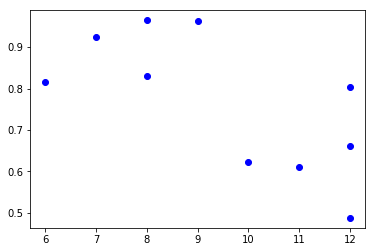

In [37]:
fig, ax = plt.subplots()
plt.plot(regression_results['num_topics'], regression_results['accuracy_topics_coded'], 'bo')

In [38]:
for product in top_ten:
    t = final_results.loc[product, 'num_topics']
    regression_results.loc[product, 'num_topics']=t
    test_pdct = df[df['ProductId']==product]

    X = test_pdct[['codecount_GOOD','codecount_BAD']]
    y = test_pdct['Sentiment']

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    regression_results.loc[product, 'accuracy_codewords'] = accuracy
    print('Product: {}'.format(product), 'Num topics: {}'.format(t), "Accuracy Score: {}".format(accuracy))

/Users/hannahmoran/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/hannahmoran/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Product: B002IEZJMA Num topics: 10 Accuracy Score: 0.7213114754098361
Product: B006MONQMC Num topics: 12 Accuracy Score: 0.6097560975609756
Product: B005ZBZLT4 Num topics: 12 Accuracy Score: 0.84251968503937
Product: B003GTR8IO Num topics: 12 Accuracy Score: 0.7142857142857143
Product: B005K4Q34S Num topics: 6 Accuracy Score: 0.8014705882352942
Product: B0013A0QXC Num topics: 8 Accuracy Score: 0.8308823529411765
Product: B000NMJWZO Num topics: 9 Accuracy Score: 0.9632352941176471
Product: B000KV61FC Num topics: 11 Accuracy Score: 0.6474820143884892
Product: B001EO5Q64 Num topics: 8 Accuracy Score: 0.971830985915493
Product: B0026RQTGE Num topics: 7 Accuracy Score: 0.9367088607594937


In [42]:
regression_results

num_topics accuracy_topics_coded accuracy_codewords  \
B002IEZJMA         10              0.622951           0.721311   
B006MONQMC         12              0.487805           0.609756   
B005ZBZLT4         12               0.80315            0.84252   
B003GTR8IO         12              0.661654           0.714286   
B005K4Q34S          6              0.816176           0.801471   
B0013A0QXC          8              0.830882           0.830882   
B000NMJWZO          9              0.963235           0.963235   
B000KV61FC         11              0.611511           0.647482   
B001EO5Q64          8              0.964789           0.971831   
B0026RQTGE          7              0.924051           0.936709   

           num_topics_valence accuracy_topics_valence  \
B002IEZJMA                NaN                     NaN   
B006MONQMC                NaN                     NaN   
B005ZBZLT4                NaN                     NaN   
B003GTR8IO                NaN                     NaN   
B005K4Q34S                NaN                     NaN   
B0013A0QXC                NaN                     NaN   
B000NMJWZO                NaN                     NaN   
B000KV61FC                NaN                     NaN   
B001EO5Q64                NaN                     NaN   
B0026RQTGE                NaN                     NaN   

           accuracy_codewords_valence  
B002IEZJMA                        NaN  
B006MONQMC                        NaN  
B005ZBZLT4                        NaN  
B003GTR8IO                        NaN  
B005K4Q34S                        NaN  
B0013A0QXC                        NaN  
B000NMJWZO                        NaN  
B000KV61FC                        NaN  
B001EO5Q64                        NaN  
B0026RQTGE                        NaN

In [41]:
regression_results.to_csv('rating_regression_results.csv')

In [81]:
import seaborn as sns
sns.set(style="white")

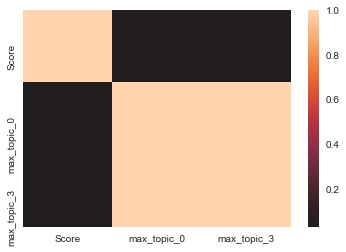

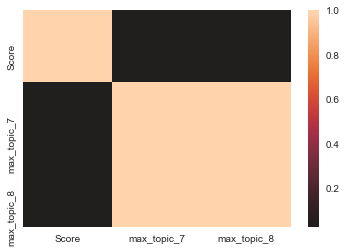

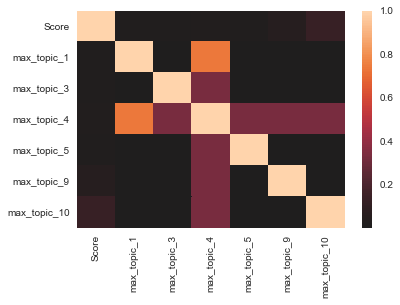

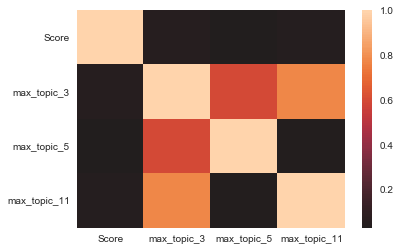

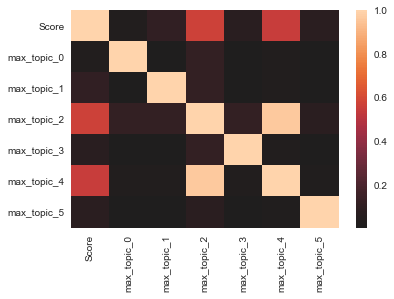

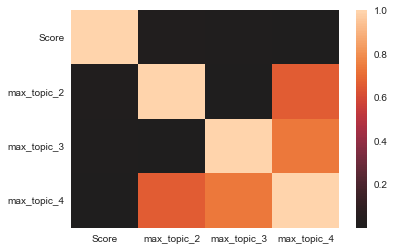

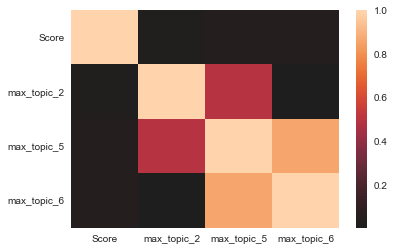

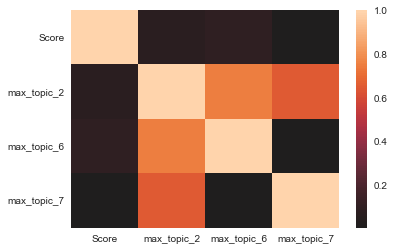

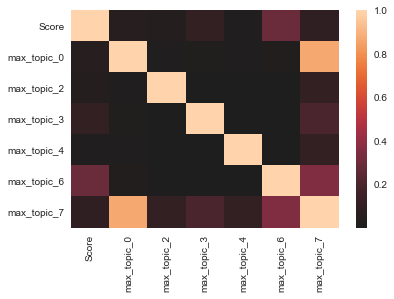

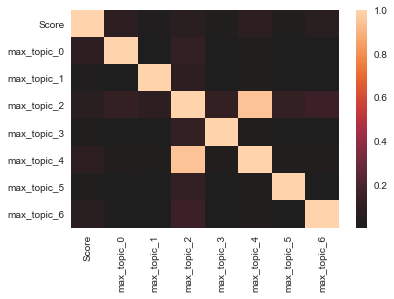

In [83]:
for product in top_ten:
    data = sub_df_ten[sub_df_ten["ProductId"]==product]
    data = data[['Score', 'max_topic']]
    data = pd.get_dummies(data, columns=['max_topic'])
    corr = abs(data.corr())
    #print(corr)
    #cmap = sns.diverging_palette(220, 10, as_cmap=True)
    fig, ax = plt.subplots()
    sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, center=0, ax=ax)

In [ ]:
corr

In [ ]:
data = pd.get_dummies(data, columns=['max_topic'])

In [ ]:
sns.heatmap(data.corr())

In [ ]:
for product in top_twenty:
    data = sub_df_twenty[sub_df_twenty["ProductId"]==product]
    data = data[['Score', 'max_topic']]
    print(product)
    print(data['max_topic'].value_counts())
    print()
    print()


In [84]:
from nltk.collocations import BigramAssocMeasures, TrigramAssocMeasures, QuadgramCollocationFinder, BigramCollocationFinder, TrigramCollocationFinder
from nltk import word_tokenize

In [105]:
test_pdct_topic = sub_df_ten.loc[(sub_df_ten["ProductId"]=='B001EO5Q64')&(sub_df_ten['max_topic']==7)]
test_pdct_words = np.concatenate(np.array([word_tokenize(r) for r in test_pdct_topic['clean_coded'].values]))

bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(test_pdct_words)
finder.apply_word_filter(lambda w: w in ('GOODREVIEW', 'BADREVIEW'))

bigrams_filter = [('does', 'not'), ('did', 'not'), ('do', 'not'), ('can', 'not'), ('have', 'not'),
                 ('have', 'been'), ('am', 'not'), ('is', 'not'), ('are', 'not'), ('would', 'be'),
                 ('would', 'not'), ('was', 'not'), ('not', 'know'), ('are', 'good')]

# filter bigrams that appear less than n times in the corpus
finder.apply_freq_filter(5)
# filter specific pairs of words that may be very common but not give much information
finder.apply_ngram_filter(lambda w1, w2: (w1, w2) in bigrams_filter)

#finder.nbest(bigram_measures.chi_sq, 30)  
finder.nbest(bigram_measures.pmi, 30)  
#finder.nbest(bigram_measures.raw_freq, 20)  

[('medium', 'chain'),
 ('bruce', 'fife'),
 ('lip', 'balm'),
 ('anti', 'bacterial'),
 ('auto', 'ship'),
 ('weight', 'loss'),
 ('diaper', 'rash'),
 ('highly', 'recommended'),
 ('conditioning', 'treatment'),
 ('room', 'temp'),
 ('subscribe', 'save'),
 ('room', 'temperature'),
 ('saturated', 'fat'),
 ('liquid', 'form'),
 ('before', 'bed'),
 ('deep', 'conditioner'),
 ('extra', 'virgin'),
 ('popcorn', 'machine'),
 ('grocery', 'store'),
 ('highly', 'recommend'),
 ('few', 'drop'),
 ('stir', 'fry'),
 ('ounce', 'tub'),
 ('melt', 'easily'),
 ('high', 'heat'),
 ('year', 'old'),
 ('no', 'longer'),
 ('turn', 'liquid'),
 ('health', 'benefit'),
 ('small', 'amount')]

In [108]:
trigram_measures = TrigramAssocMeasures()
finder = TrigramCollocationFinder.from_words(test_pdct_words)
#finder = TrigramCollocationFinder.from_words(test_pdct_words, window_size=5)

trigrams_filter = [('does', 'not', 'have'), ('did', 'not', 'hav'), ('do', 'not', 'have'), ('can', 'not', 'have'), 
                   ('have', 'not', 'been'), ('do', 'not', 'know'), ('do', 'not', 'like'), ('do', 'not', 'feel'), ('do', 'not', 'get'),
                  ('do', 'not', 'leave'), ('do', 'not', 'want'), ('do', 'not', 'work')]
finder.apply_ngram_filter(lambda w1, w2, w3: (w1, w2, w3) in trigrams_filter)
finder.apply_word_filter(lambda w: w in ('GOODREVIEW', 'BADREVIEW', 'be', 'coconut', 'oil'))


finder.apply_freq_filter(4) 
sorted(finder.nbest(trigram_measures.chi_sq, 30))
#sorted(finder.nbest(trigram_measures.pmi, 30))

[('can', 'not', 'beat'),
 ('can', 'not', 'believe'),
 ('can', 'not', 'wait'),
 ('deep', 'conditioner', 'hair'),
 ('do', 'not', 'even'),
 ('do', 'not', 'make'),
 ('do', 'not', 'need'),
 ('do', 'not', 'taste'),
 ('do', 'not', 'think'),
 ('do', 'not', 'use'),
 ('face', 'body', 'moisturizer'),
 ('go', 'long', 'way'),
 ('have', 'try', 'several'),
 ('health', 'food', 'store'),
 ('just', 'do', 'not'),
 ('little', 'go', 'long'),
 ('many', 'health', 'benefit'),
 ('moisturizer', 'do', 'not'),
 ('not', 'go', 'wrong'),
 ('not', 'too', 'strong'),
 ('nutiva', 'organic', 'extra'),
 ('organic', 'extra', 'virgin'),
 ('purchase', 'two', 'pack'),
 ('say', 'do', 'not'),
 ('skin', 'do', 'not'),
 ('so', 'do', 'not'),
 ('so', 'many', 'us'),
 ('try', 'several', 'brand'),
 ('use', 'place', 'butter'),
 ('ve', 'try', 'several')]

In [110]:
from nltk.metrics.association import QuadgramAssocMeasures

quadgram_measures = QuadgramAssocMeasures()
finder = QuadgramCollocationFinder.from_words(test_pdct_words)
#finder = QuadgramCollocationFinder.from_words(test_pdct_words, window_size=5)
finder.apply_word_filter(lambda w: w in ('VGOODREVIEW', 'GOODREVIEW', 'BADREVIEW', 'VBADREVIEW', 'be', 'coconut', 'oil'))
finder.apply_freq_filter(4) 
sorted(finder.nbest(quadgram_measures.pmi, 30)) 
#sorted(finder.nbest(quadgram_measures.raw_freq, 30))

[('have', 'not', 'try', 'cook'),
 ('have', 'so', 'many', 'us'),
 ('little', 'go', 'long', 'way'),
 ('nutiva', 'organic', 'extra', 'virgin'),
 ('so', 'do', 'not', 'have')]